## Some useful imports

In [1]:
import nltk
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

## Getting email text

In [2]:
emails = pd.read_csv("./hillary-clinton-emails/Emails.csv", usecols=["RawText"])

In [3]:
emails.head()

,RawText
0,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


Concatenating all the e-mails into one big text.

In [4]:
original_text = " ".join(emails.RawText)

### First raw word count 

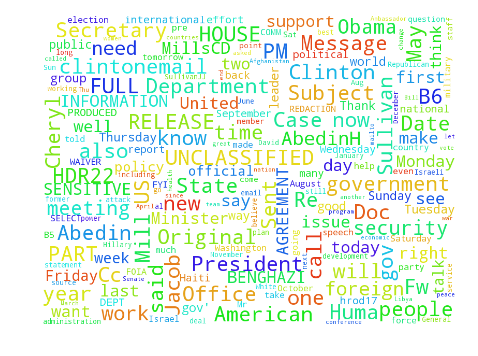

In [5]:
def show_wordCloud(text):
    # lower max_font_size
    wordcloud = WordCloud(
        max_font_size=40, 
        background_color='white',
        width=800,
        height=600
    ).generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

show_wordCloud(original_text)

We can see different kind of patterns:
- generic words in emails: re, part, date, sent, subject, message
- classical words: will, want, many
- uppercase vs lowercase
- accronyms
- etc.

Pros:
- no processing, pure data: no risk of having drop important part or change the meaning

Cons:
- difficult to extract important words: they are hidden in the mass
- not homogenous: year and years are counted separately
- noisy: some words do not have a single meaning themselves, the need a context (e.g. stop words)

## Processing pipeline

Here is the pipeline we choosed to implement:
- tokenization
- lowercasing
- stop word removal
- lemmatization
- stemming
- url/email removal: although they not appear in the world cloud url are often present in mails and can be blacklisted with `./_@:` which are usally part of desired words

In [6]:
tokens = nltk.word_tokenize(original_text)

In [7]:
def lower_case(tokens):
    return [token.lower() for token in tokens]

tokens = lower_case(tokens)

In [8]:
def remove_stop_words(tokens):
    return np.array(tokens)[np.in1d(tokens, stopwords.words("english"), invert=True)]

tokens = remove_stop_words(tokens)

In [9]:
def lemmatization(tokens):
    wordnet_lemmatizer = WordNetLemmatizer()
    return [wordnet_lemmatizer.lemmatize(token) for token in tokens]

tokens = lemmatization(tokens)

In [10]:
def stemming(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

tokens = stemming(tokens)

In [11]:
def remove_url_email(tokens):
    blacklist_chars = ['_', '.', ':' , '@', '/']
    return [token for token in tokens if not np.in1d(list(token), blacklist_chars).any()]
    
tokens = remove_url_email(tokens)

In [12]:
text = " ".join(tokens)

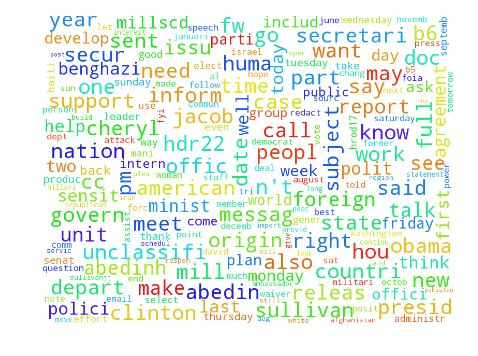

In [13]:
show_wordCloud(text)

The result has improved a lot, however there are still issues:
- generic words in emails: this would require extending the stop words list with targetted words and would require more analysis
- classical words: this would require extending the stop words list or use "zpif score" to avoid considering them
- accronyms: this would require to generate a list corresponding term which is indeed a hard problem

Pros:
- more variaty, more homogenous
- similar words put together whenever possible
- avoid stop words
    
Cons:
- might have influence the content: in case pipeline/methods introducing some biais
- still some issues with normalization: n't should be here

## Only nouns

One could also try to keep only (proper) nouns as verbs, adjectives and adverbs might have a very generic meaning (e.g. also, send). Using a POS tagging just after tokenization, we can discard the others.

In [14]:
def keep_nouns(tokens):
    tags = nltk.pos_tag(set(tokens))
    to_keep_tag = ['NN', 'NNS', 'NNP', 'NNPS']
    to_keep_tokens = [tok for tok, tag in tags if tag in to_keep_tag]
    return np.array(tokens)[np.in1d(tokens, to_keep_tokens)]

In [15]:
tokens2 = nltk.word_tokenize(original_text)
tokens2 = keep_nouns(tokens2)
tokens2 = lower_case(tokens2)
tokens2 = remove_stop_words(tokens2)
tokens2 = lemmatization(tokens2)
tokens2 = stemming(tokens2)
tokens2 = remove_url_email(tokens2)

In [16]:
nouns = " ".join(tokens2)

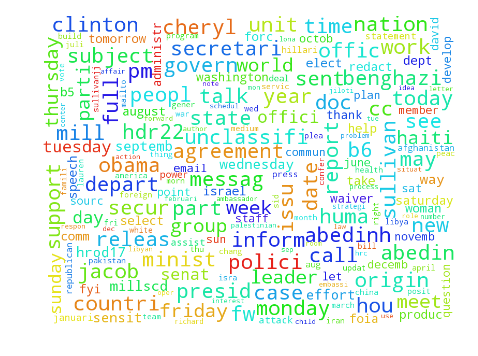

In [17]:
show_wordCloud(nouns)

Although this is more aggressive than the previous trials, this world cloud gives a better overview of the general content. The non-nouns are might be due to english verbs/nouns duality.